In [35]:
#Data Collection

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
# Paths to your good and faulty tire images
good_tire_path = 'D:/vijay Upgrad/Capstone Project/Digital images of defective and good condition tyres/good'
faulty_tire_path = 'D:/vijay Upgrad/Capstone Project/Digital images of defective and good condition tyres/defective'

# Load data function
def load_data(good_tire_path, faulty_tire_path):
    good_tires = [os.path.join(good_tire_path, img) for img in os.listdir(good_tire_path)]
    faulty_tires = [os.path.join(faulty_tire_path, img) for img in os.listdir(faulty_tire_path)]
    return good_tires, faulty_tires

good_tires, faulty_tires = load_data(good_tire_path, faulty_tire_path)
print(f"Good tires: {len(good_tires)} \nFaulty tires: {len(faulty_tires)}")

Good tires: 828 
Faulty tires: 1028


In [37]:
#Data Preprocessing

In [9]:
# Creating an ImageDataGenerator for preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of the data for validation
)

# Load training and validation data using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    directory='D:/vijay Upgrad/Capstone Project/Digital images of defective and good condition tyres',
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary',  # Binary classification (good vs defective)
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    directory='D:/vijay Upgrad/Capstone Project/Digital images of defective and good condition tyres',
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary',  # Binary classification (good vs defective)
    subset='validation'  # Set as validation data
)

Found 1486 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


In [ ]:
#Model Selection and Training

In [10]:
# Function to create CNN model
def create_cnn_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential([
        Input(shape=(150, 150, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
    
# Create the CNN model
cnn_model = create_cnn_model()


In [11]:
# Train the model with checkpoints
checkpoint = ModelCheckpoint(
    filepath='best_model_weights.weights.h5',  # Use .weights.h5 for saving weights only
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.4875 - loss: 0.9796 - val_accuracy: 0.4489 - val_loss: 0.7378
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 400ms/step - accuracy: 0.4375 - loss: 0.7977 - val_accuracy: 0.4943 - val_loss: 0.6654
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.6290 - loss: 0.6438 - val_accuracy: 0.6364 - val_loss: 0.6456
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.6429 - loss: 0.6103 - val_accuracy: 0.5938 - val_loss: 0.7246
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7006 - loss: 0.5935 - val_accuracy: 0.8125 - val_loss: 0.5109
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 388ms/step - accuracy: 0.6875 - loss: 0.5212 - val_accuracy: 0.8182 - val_loss: 0.5035
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7214 - loss: 0.5692 - val_accuracy: 0.7784 - val_loss: 0.5306
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 383ms/step - accuracy: 0.8750 - loss: 0.4585 - val_accuracy: 0.

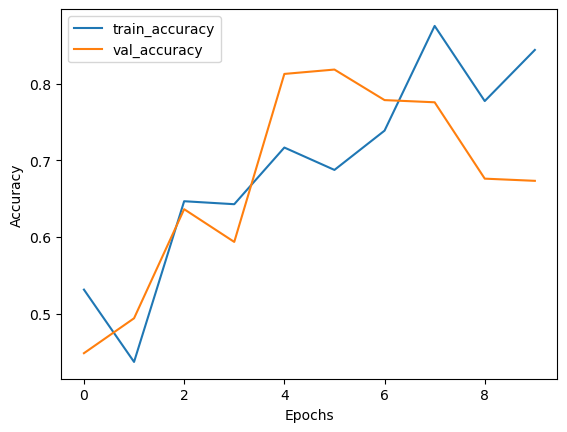

In [12]:
# Plotting CNN Training History 
plt.plot(history.history['accuracy'], label='train_accuracy') 
plt.plot(history.history['val_accuracy'], label='val_accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show()

In [ ]:
# Preparing data for other models (Logistic Regression, Decision Tree, Random Forest)

In [13]:
# Flattening the images for non-CNN models requires loading them again.
X = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))) / 255.0 for img_path in good_tires + faulty_tires])
y = np.array([0] * len(good_tires) + [1] * len(faulty_tires))  # Labels: 0 for good tires and 1 for faulty tires

# Split into train and test sets (80% train, 20% test)
X_train_flattened, X_test_flattened, y_train, y_test = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=42)

In [14]:
# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_flattened, y_train)
y_pred_log_reg = log_reg.predict(X_test_flattened)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Test Accuracy (Logistic Regression): {accuracy_log_reg:.2f}")

Test Accuracy (Logistic Regression): 0.62


In [15]:
# Cross-Validation for Logistic Regression 
scores_log_reg = cross_val_score(log_reg, X.reshape(X.shape[0], -1), y, cv=5, scoring='accuracy') 
print(f"Cross-Validation Accuracy (Logistic Regression): {np.mean(scores_log_reg):.2f}")

Cross-Validation Accuracy (Logistic Regression): 0.53


In [16]:
# Decision Tree Model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_flattened, y_train)
y_pred_dt = dt_model.predict(X_test_flattened)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Test Accuracy (Decision Tree): {accuracy_dt:.2f}")

Test Accuracy (Decision Tree): 0.65


In [17]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_flattened, y_train)
y_pred_rf = rf_model.predict(X_test_flattened)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test Accuracy (Random Forest): {accuracy_rf:.2f}")


Test Accuracy (Random Forest): 0.74


In [18]:
# Cross-Validation for Random Forest 
scores_rf = cross_val_score(rf_model, X.reshape(X.shape[0], -1), y, cv=5, scoring='accuracy') 
print(f"Cross-Validation Accuracy (Random Forest): {np.mean(scores_rf):.2f}")

Cross-Validation Accuracy (Random Forest): 0.61


In [ ]:
#Model Evaluation

In [19]:
# CNN Model Evaluation
val_loss, val_accuracy = cnn_model.evaluate(validation_generator)
print(f'Validation Accuracy (CNN): {val_accuracy:.2f}')

# Accuracy of other models
print(f"Test Accuracy (Logistic Regression): {accuracy_log_reg:.2f}")
print(f"Test Accuracy (Decision Tree): {accuracy_dt:.2f}")
print(f"Test Accuracy (Random Forest): {accuracy_rf:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6837 - loss: 0.6367
Validation Accuracy (CNN): 0.67
Test Accuracy (Logistic Regression): 0.62
Test Accuracy (Decision Tree): 0.65
Test Accuracy (Random Forest): 0.74
